In [1]:
# Imports
from src.data_retrieval import init_osm
from src.preprocessing import load_roads, load_railways, load_water_polygons, get_local_crs, reproject_all, build_water_edges, prepare_water_geometries
from src.prepare_pois import load_pois_with_green, prepare_pois, assign_pois_to_blocks
from src.process_blocks import construct_blocks, filter_water_blocks, filter_small_blocks, filter_irregular_blocks, remove_false_water_blocks
from src.plotting import plot_block_graph, plot_ge_heatmap, plot_variance
from src.construct_graph import build_block_graph
from src.network_analysis import get_largest_component, prepare_category_dicts, compute_generalized_euclidean_matrix, load_Q, compute_and_store_Q, compute_variance, compute_z_scores
from src.network_distance import ge, _ge_Q, variance, _resistance, calculate_spl


Setup

In [2]:
CITY_NAME = "Copenhagen"
# CITY_NAME = "Gdansk"

# Initialize OSM
osm, boundary = init_osm(CITY_NAME)

Downloaded Protobuf data 'Copenhagen.osm.pbf' (39.17 MB) to:
'/home/zuziaderylo/masters_thesis/data/raw/Copenhagen.osm.pbf'


In [3]:
roads = load_roads(osm)
railways = load_railways(osm)
water_polygons = load_water_polygons(osm)
pois = load_pois_with_green(osm)

/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


Loaded 29806 regular POIs
Loaded 981 green-space features
Total combined POIs: 30787


In [4]:
# Compute city-local UTM projection
local_epsg = get_local_crs(boundary)
print(f"Using local CRS: EPSG:{local_epsg}")

# Reproject all at once
layers = {
    "boundary": boundary,
    "roads": roads,
    "railways": railways,
    "water_polygons": water_polygons,
    "pois": pois
}
layers = reproject_all(layers, local_epsg)

# Unpack
boundary = layers["boundary"]
roads = layers["roads"]
railways = layers["railways"]
water_polygons = layers["water_polygons"]
pois = layers["pois"]

Using local CRS: EPSG:32633


In [5]:
print(boundary.crs)

EPSG:32633


In [6]:
# Build water edges after reprojection
water_edges = build_water_edges(layers["water_polygons"])

# Change water geometries
water_polygons = prepare_water_geometries(water_polygons)

In [7]:
# Prepare pois
pois = prepare_pois(pois=pois)

Assigned categories for 23171 POIs (75.4% coverage)


In [8]:
len(roads)

76906

In [9]:
len(water_edges)

3052

In [10]:
len(railways)

4594

In [11]:
# Create initial blocks
initial_blocks = construct_blocks(roads, railways, water_edges)

len(initial_blocks)

8455


Iteration 1:
Threshold = 547.10 m²
Small blocks found = 1972
 Merged 1972 small blocks.
 Remaining blocks = 5916

Iteration 2:
Threshold = 547.10 m²
Small blocks found = 0
No small blocks left


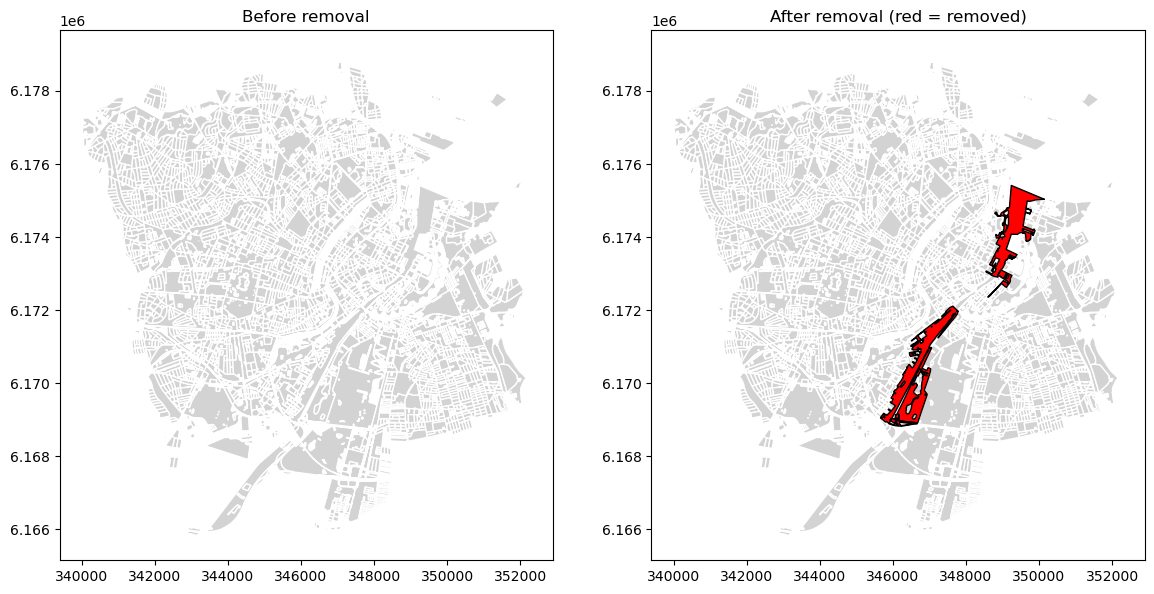

Removed 2 suspected false-water blocks (area>100%, compactness<4%).


/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be s

5326


/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [12]:
# Process blocks
blocks_no_water = filter_water_blocks(initial_blocks, water_polygons)
blocks_no_small = filter_small_blocks(blocks_no_water)
blocks_cleaned = remove_false_water_blocks(blocks_no_small, area_quantile=0.999, compactness_quantile=0.04,poi_column="poi_count")
blocks_no_irregular = filter_irregular_blocks(blocks_cleaned)

blocks = blocks_no_irregular

print(len(blocks))

In [13]:
blocks_with_pois = assign_pois_to_blocks(pois, blocks)

blocks = blocks_with_pois

POIs assigned to 2818 blocks (out of 5326)


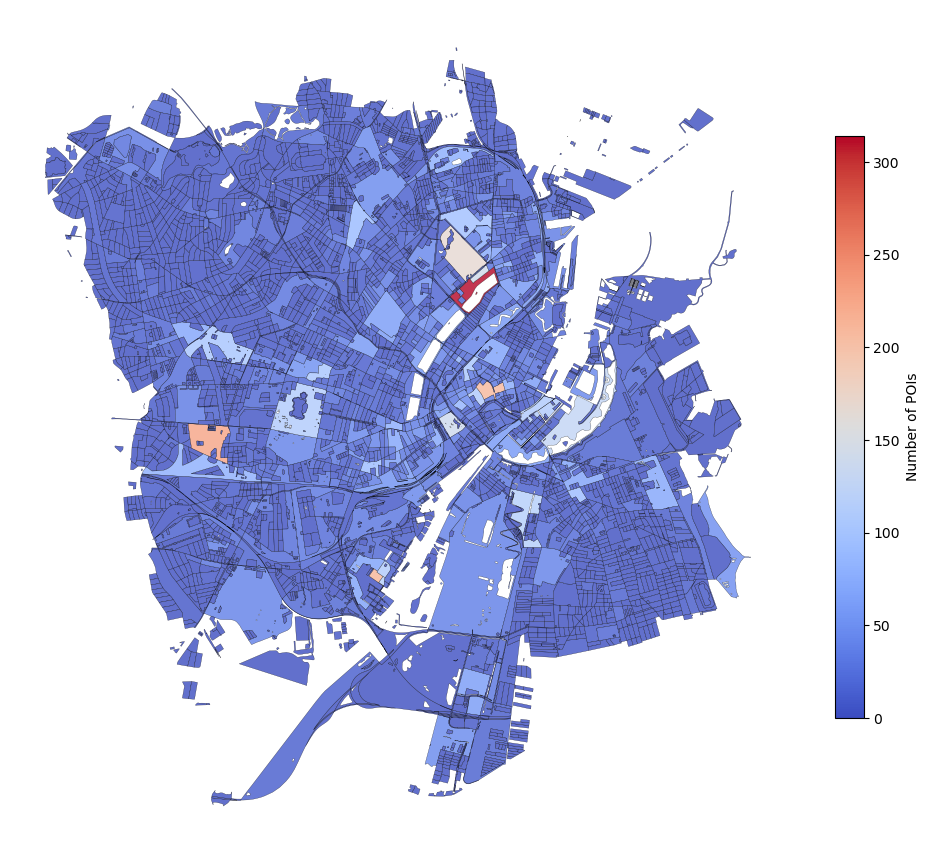

In [14]:
from matplotlib import pyplot as plt

# Plot heatmap of POI counts
fig, ax = plt.subplots(figsize=(10, 10))

# Plot blocks, colored by number of POIs
blocks_with_pois.plot(
    ax=ax,
    column="poi_count",
    cmap="coolwarm",
    legend=True,
    legend_kwds={"label": "Number of POIs", "shrink": 0.6},
    edgecolor="black",
    linewidth=0.2,
    alpha = 0.8
)

# Title and formatting
# ax.set_title("Heatmap of POI Density per Block", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

Graph

In [15]:
# Build graph from blocks with POIs
G = build_block_graph(blocks_with_pois)

Graph constructed: 5326 nodes, 15746 edges


In [16]:
plot_block_graph(G, blocks, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1200x1200 with 2 Axes>,
 <Axes: title={'center': 'Copenhagen Network Graph'}>)

In [17]:
# Select largest connected component
G_largest = get_largest_component(G)

Graph has 83 components.
Largest component: 5170 nodes, 15650 edges.


In [18]:
# Compute Q
Q = compute_and_store_Q(G_largest, CITY_NAME)

In [19]:
# Load 
G_largest, Q = load_Q(CITY_NAME)

Graph nodes: 5170, Q shape: (5170, 5170)


In [20]:
# Prepare category dictionaries
category_counts = blocks_with_pois.attrs["category_counts"]
category_dicts_largest = prepare_category_dicts(category_counts, G_largest)

In [21]:
# Compute GE matrix
df_ge = compute_generalized_euclidean_matrix(G_largest, category_dicts_largest, ge_func=ge, Q_func=lambda G: Q)


In [22]:
# Plot heatmap
plot_ge_heatmap(df_ge, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Copenhagen Generalized Euclidean Distance between Amenity Categories'}>)

In [23]:
# Precompute resistance once
def precompute_resistance(G_largest):
    resistance_matrix = _resistance(G_largest)

    return resistance_matrix

In [24]:
resistance_matrix = precompute_resistance(G_largest)

In [25]:
# Compute variance for each category (using precomputet resistance matrix)
variance_categories = compute_variance(category_dicts_largest, G_largest, resistance_matrix)

                          variance
food                      0.310175
education                 0.373631
green_spaces              0.534928
infrastructure_transport  0.409770
other_daily_utilities     0.396827
retail                    0.277116
culture_leisure           0.312247
public_services           0.329412
healthcare                0.375680


In [26]:
plot_variance(variance_categories, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Copenhagen Variance per Amenity Category'}, ylabel='Variance'>)

In [27]:
import random
import numpy as np


# Generate distribution of variances from shuffled pois
def shuffled_variances(v_dict, G, resistance_matrix, n_iter=1000):
    # Store variance values from each shuffle
    results = []

    #Extract node IDs and their associated values separately
    nodes = list(v_dict.keys()) # stay fix
    values = list(v_dict.values()) # to shuffle

    # Perform random shuffling multiple times
    for _ in range(n_iter):
        # Shuffle POI values
        random.shuffle(values)

        # Reassign shuffled values to nodes
        shuffled_v = dict(zip(nodes, values))

        # Compute variance for this shuffled configuration
        var_random = variance(shuffled_v, G, shortest_path_lengths=resistance_matrix, kernel="resistance")
        
        # Store
        results.append(var_random)

    return np.array(results)


In [28]:
import pandas as pd

# For each POI category:
# 1. Compute real variance
# 2. Generate random variance distribution
# 3. Compute z-score
def compute_z_scores(category_dicts, G, resistance_matrix, n_iter=1000):
    # Store results for all categories
    random_stats = {}

    # Iterate over each POI category
    for category, v_dict in category_dicts.items():
        # Compute real variance
        real_var = variance(v_dict, G,
                            shortest_path_lengths=resistance_matrix,
                            kernel="resistance")
        
        # Generate dstribution from shuffled data
        rand_vars = shuffled_variances(v_dict, G, resistance_matrix, n_iter)

        # Compute mean and standard deviation
        mean_rand = np.mean(rand_vars)
        std_rand = np.std(rand_vars)

        # Compute z-score
        # Positive z => more spread out than random
        # Negative z => more clustered than random
        z = (real_var - mean_rand) / std_rand if std_rand > 0 else np.nan

        # Store all results for this category: variance, average of random variances, standard deviation if random variances, normalized difference
        random_stats[category] = {
            "real_var": real_var,
            "mean_rand": mean_rand,
            "std_rand": std_rand,
            "z_score": z,
            "rand_vars": rand_vars
        }

    # Return as dataframe
    return pd.DataFrame.from_dict(random_stats, orient="index")


In [29]:
df_z = compute_z_scores(category_dicts_largest, G_largest, resistance_matrix, n_iter=1000)

In [30]:
# Store after computing df_z
SAVE_DIR = "data/processed"
df_z.to_csv(f"{SAVE_DIR}/{CITY_NAME}_results_z_scores.csv", index=True)

In [31]:
def plot_variance_distribution_from_results(category, df_z):
    rand_vars = df_z.loc[category, "rand_vars"]
    real_var = df_z.loc[category, "real_var"]
    mean_rand = df_z.loc[category, "mean_rand"]
    std_rand = df_z.loc[category, "std_rand"]
    z = df_z.loc[category, "z_score"]

    plt.figure(figsize=(8,5))
    plt.hist(rand_vars, bins=30, color="lightblue", edgecolor="black", alpha=0.7)
    plt.axvline(real_var, color="red", linestyle="--", label=f"Real var = {real_var:.4f}")
    plt.axvline(mean_rand, color="black", linestyle=":", label=f"Mean = {mean_rand:.4f}")
    plt.title(f"{category} — Z = {z:.2f}")
    plt.xlabel("Variance")
    plt.ylabel("Count")
    plt.legend()
    plt.show()


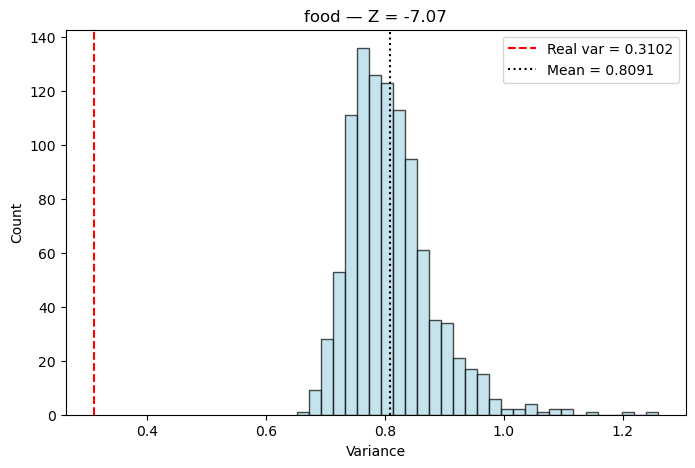

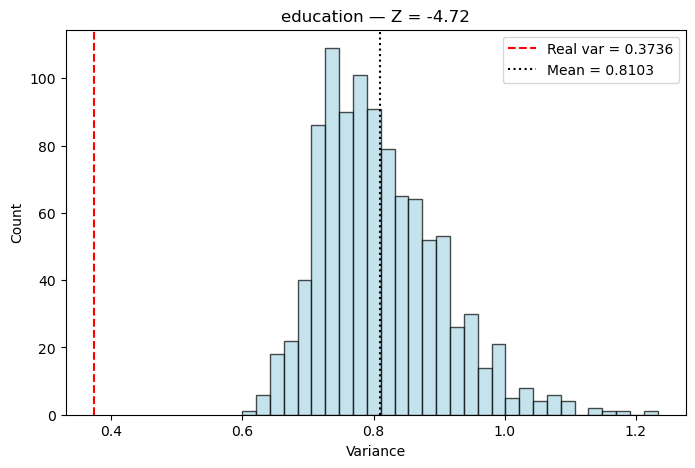

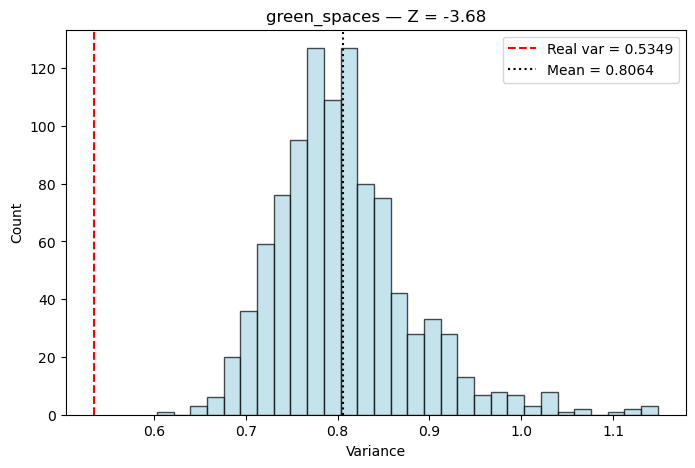

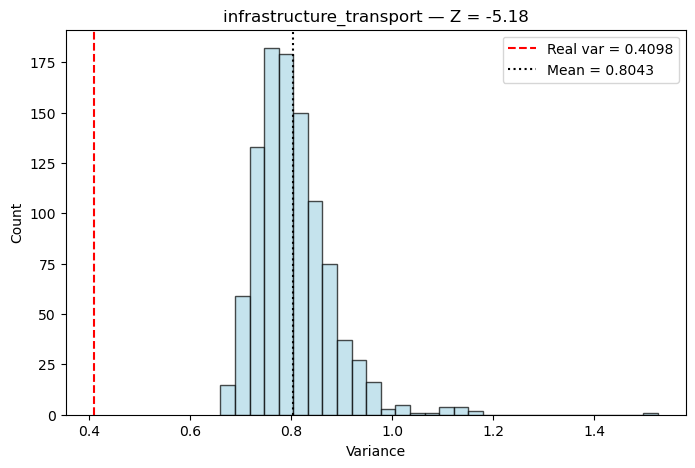

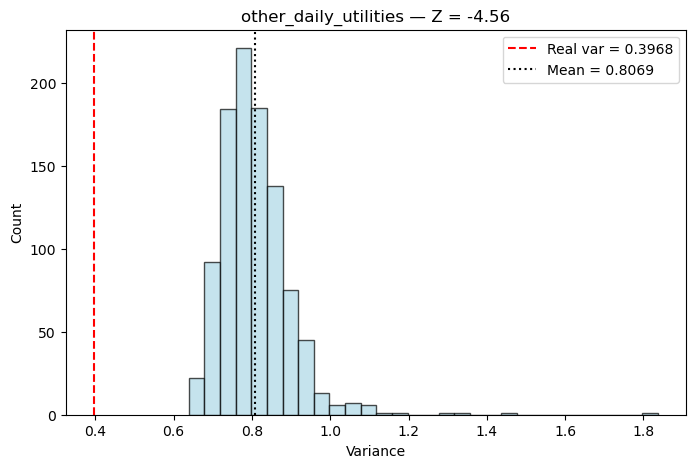

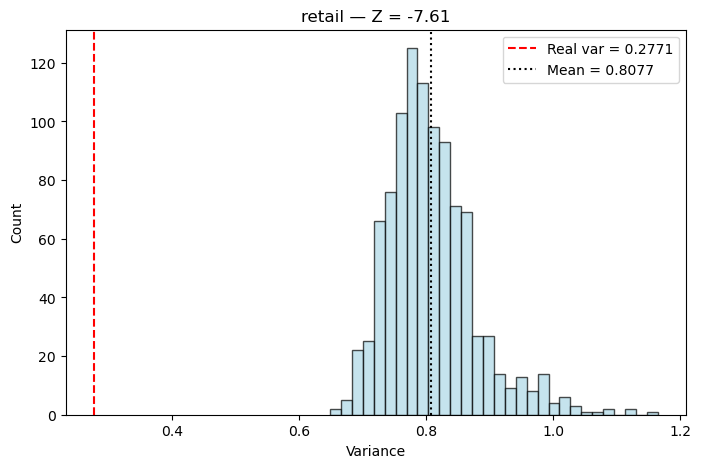

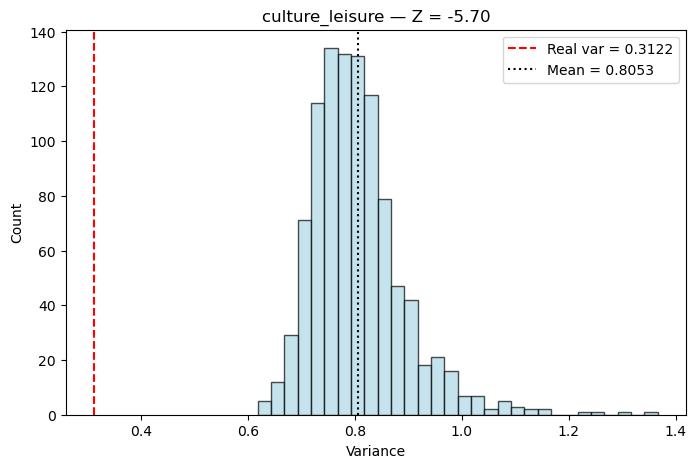

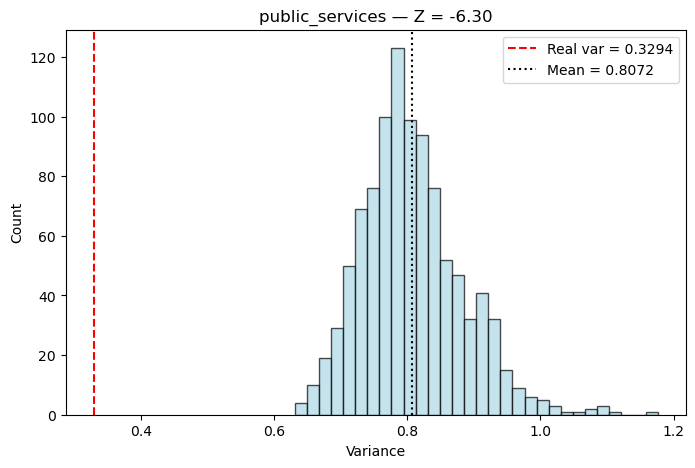

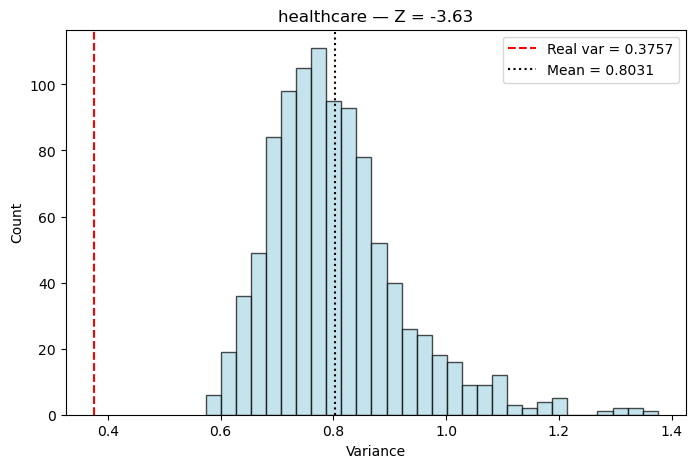

In [32]:
for category in df_z.index:
    plot_variance_distribution_from_results(category, df_z)


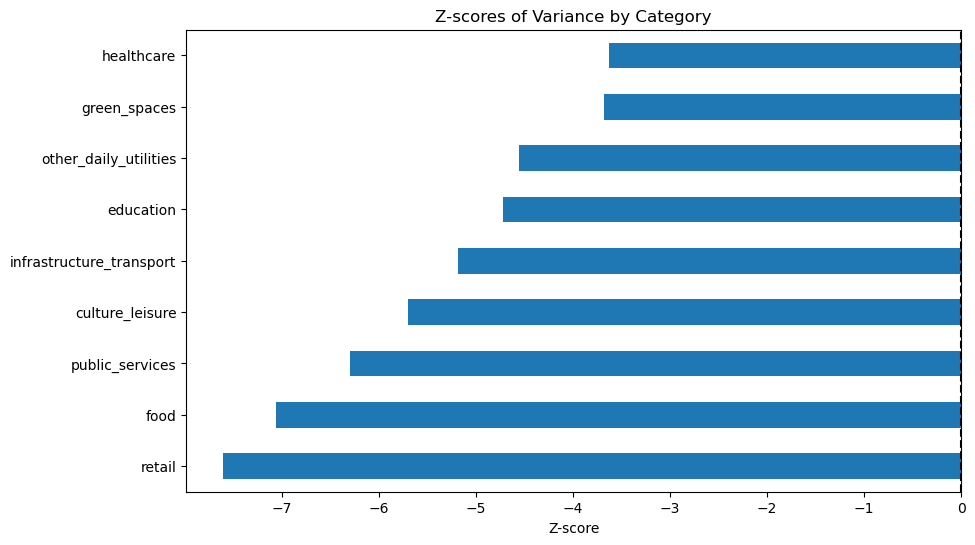

In [33]:
df_z["z_score"].sort_values().plot(kind="barh", figsize=(10,6))
plt.axvline(0, color="black", linestyle="--")
plt.title("Z-scores of Variance by Category")
plt.xlabel("Z-score")
plt.show()

In [45]:
z_scores = df_z["z_score"].values

In [46]:
print("df_ge index:", df_ge.index.tolist())
print("df_z columns:", df_z.columns.tolist())
print("First few df_z rows:")
print(df_z.head())


df_ge index: ['food', 'education', 'green_spaces', 'infrastructure_transport', 'other_daily_utilities', 'retail', 'culture_leisure', 'public_services', 'healthcare']
df_z columns: ['real_var', 'mean_rand', 'std_rand', 'z_score', 'rand_vars']
First few df_z rows:
                          real_var  mean_rand  std_rand   z_score  \
food                      0.310175   0.809118  0.070613 -7.065865   
education                 0.373631   0.810266  0.092505 -4.720106   
green_spaces              0.534928   0.806437  0.073735 -3.682231   
infrastructure_transport  0.409770   0.804298  0.076113 -5.183484   
other_daily_utilities     0.396827   0.806887  0.089951 -4.558709   

                                                                  rand_vars  
food                      [0.7446496545783412, 0.7869601679830502, 0.822...  
education                 [0.8103533061956333, 0.7365026002960685, 0.709...  
green_spaces              [0.7745423761459067, 0.9303432255070668, 0.801...  
infrastruc

In [47]:
print("Categories in GE:", df_ge.index.tolist())
print("Categories in z:", df_z.index.tolist())

# Check if they contain exactly the same categories
print("Same categories?", set(df_ge.index) == set(df_z.index))


Categories in GE: ['food', 'education', 'green_spaces', 'infrastructure_transport', 'other_daily_utilities', 'retail', 'culture_leisure', 'public_services', 'healthcare']
Categories in z: ['food', 'education', 'green_spaces', 'infrastructure_transport', 'other_daily_utilities', 'retail', 'culture_leisure', 'public_services', 'healthcare']
Same categories? True


In [48]:
df_z_aligned = df_z.reindex(df_ge.index)
z_scores = df_z_aligned["z_score"].values


In [49]:
import numpy as np

def compute_livability_from_matrix(df_ge, z_scores):
    GE = df_ge.values
    z = np.abs(np.array(z_scores, dtype=float))
    scaled = z[:, None] * GE
    total = scaled.sum()
    return 1 / total if total != 0 else np.nan

livability = compute_livability_from_matrix(df_ge, z_scores)
print("Livability score:", livability)


Livability score: 0.031093550170208036


In [50]:
for cat, z in zip(df_ge.index, z_scores):
    print(f"{cat}: {z}")


food: -7.065864836589996
education: -4.720105843263381
green_spaces: -3.6822306222032757
infrastructure_transport: -5.183484377334661
other_daily_utilities: -4.5587089394031155
retail: -7.607079165315961
culture_leisure: -5.7015253989048205
public_services: -6.2957488755340325
healthcare: -3.6253657846397265


In [51]:
# import numpy as np
# import pandas as pd

# # z-scores
# z = np.array([-11, -7, -5])

# # GE matrix (numpy version)
# GE = np.array([[0, 1, 2],
#                [1, 0, 3],
#                [2, 3, 0]])

# # GE matrix (dataframe version)
# df_ge = pd.DataFrame(GE, columns=["POI1", "POI2", "POI3"], index=["POI1", "POI2", "POI3"])


In [56]:
print(type(z_scores), np.shape(z_scores))


<class 'numpy.ndarray'> (9,)


In [54]:
compute_livability_from_matrix(df_ge, z_scores)

0.031093550170208036

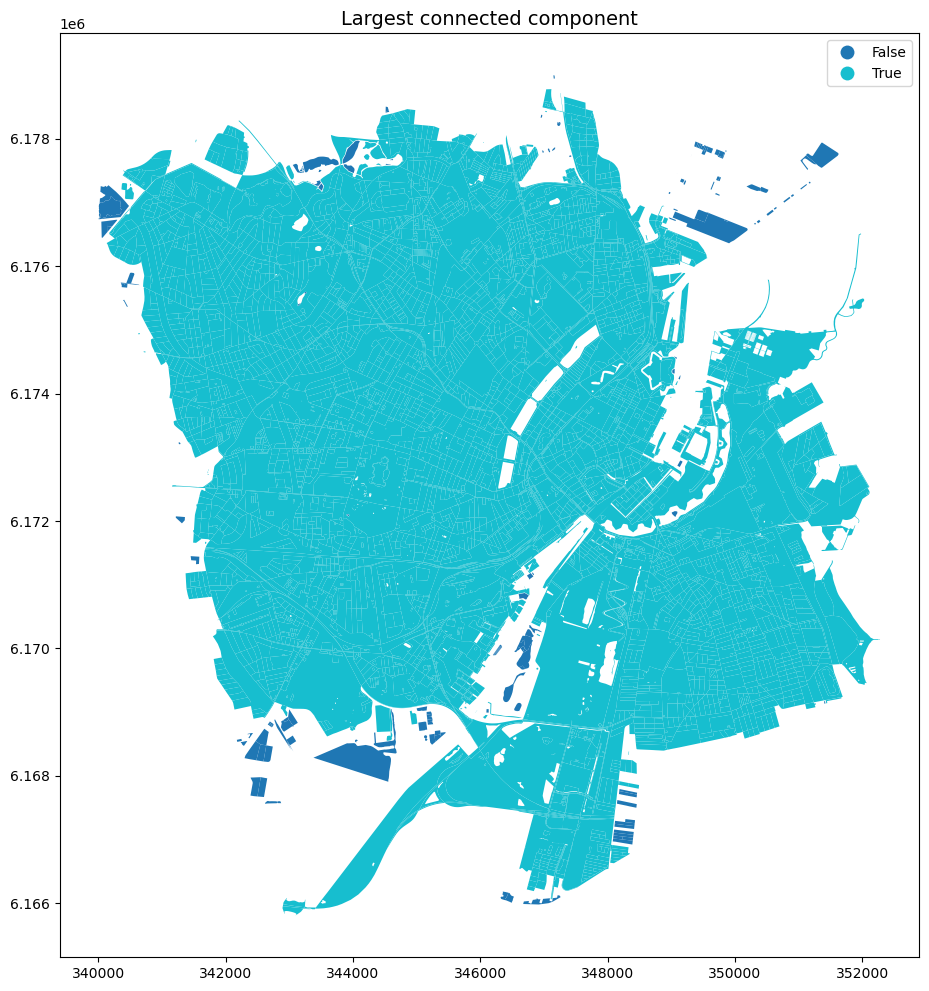

In [55]:
import networkx as nx
import matplotlib.pyplot as plt


largest = max(nx.connected_components(G), key=len)
blocks["in_largest"] = blocks["block_id"].isin(largest)


fig, ax = plt.subplots(figsize=(12, 12))
blocks.plot(column="in_largest", legend=True, ax=ax)
plt.title("Largest connected component", fontsize=14)
plt.show()
